# Pre-trained models and transfer learning

Training CNNs can take a lot of time and a lot of data is required for that task. Much of the time is spent to experimenting to find the best low-level filters that a network needs to extract patterns from the images. A natural question arises - can we use a neural network trained on one dataset and adapt it to classifying different images without full training process?

This approach is called **transfer learning**, because we transfer some knowledge from one neural network model to another. In transfer learning, we typically start with a pre-trained model, which has been trained on some large image dataset, such as **ImageNet**. Those models can already do a good job extracting different features from generic images, and in many cases just building a classifier on top of those extracted features can yield a good result.

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Load tfcv.py module
!wget -O tfcv.py -q https://github.com/MicrosoftDocs/tensorflow-learning-path/raw/main/computer-vision-tf/tfcv.py
from tfcv import *

## Cats vs. Dogs Dataset

In this unit, we will solve a real-life problem of classifying images of cats and dogs. For this reason, we will use [Kaggle Cats vs. Dogs Dataset](https://www.kaggle.com/c/dogs-vs-cats), which can also be downloaded [from Microsoft](https://www.microsoft.com/en-us/download/details.aspx?id=54765).

Let's download this dataset and extract it into `data` directory (*this process may take some time*!):

In [3]:
if not os.path.exists('data/kagglecatsanddogs_3367a.zip'):
    !mkdir -p data
    !wget -P data -q https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

In [4]:
import zipfile
if not os.path.exists('data/PetImages'):
    with zipfile.ZipFile('data/kagglecatsanddogs_3367a.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

Unfortunately, there are some corrupt image files in the dataset. We need to do a quick cleaning to check for corrupted files. We moved the code to verify the dataset into a module.

In [5]:
check_image_dir('data/PetImages/Cat/*.jpg')
check_image_dir('data/PetImages/Dog/*.jpg')

Corrupt image or wrong format: data/PetImages/Cat/8958.jpg
Corrupt image or wrong format: data/PetImages/Cat/2189.jpg
Corrupt image or wrong format: data/PetImages/Cat/4629.jpg
Corrupt image or wrong format: data/PetImages/Cat/2663.jpg
Corrupt image or wrong format: data/PetImages/Cat/4833.jpg
Corrupt image or wrong format: data/PetImages/Cat/10073.jpg
Corrupt image or wrong format: data/PetImages/Cat/6768.jpg
Corrupt image or wrong format: data/PetImages/Cat/3967.jpg
Corrupt image or wrong format: data/PetImages/Cat/850.jpg
Corrupt image or wrong format: data/PetImages/Cat/6486.jpg
Corrupt image or wrong format: data/PetImages/Cat/7642.jpg
Corrupt image or wrong format: data/PetImages/Cat/1757.jpg
Corrupt image or wrong format: data/PetImages/Cat/910.jpg
Corrupt image or wrong format: data/PetImages/Cat/4929.jpg
Corrupt image or wrong format: data/PetImages/Cat/10820.jpg
Corrupt image or wrong format: data/PetImages/Cat/6900.jpg
Corrupt image or wrong format: data/PetImages/Cat/9619.j

/anaconda/envs/py38_tensorflow/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Corrupt image or wrong format: data/PetImages/Dog/2688.jpg
Corrupt image or wrong format: data/PetImages/Dog/10173.jpg
Corrupt image or wrong format: data/PetImages/Dog/11285.jpg
Corrupt image or wrong format: data/PetImages/Dog/11590.jpg
Corrupt image or wrong format: data/PetImages/Dog/5955.jpg
Corrupt image or wrong format: data/PetImages/Dog/6718.jpg
Corrupt image or wrong format: data/PetImages/Dog/6500.jpg
Corrupt image or wrong format: data/PetImages/Dog/11675.jpg
Corrupt image or wrong format: data/PetImages/Dog/7133.jpg
Corrupt image or wrong format: data/PetImages/Dog/5263.jpg
Corrupt image or wrong format: data/PetImages/Dog/6318.jpg
Corrupt image or wrong format: data/PetImages/Dog/2317.jpg
Corrupt image or wrong format: data/PetImages/Dog/11912.jpg
Corrupt image or wrong format: data/PetImages/Dog/2877.jpg
Corrupt image or wrong format: data/PetImages/Dog/6059.jpg
Corrupt image or wrong format: data/PetImages/Dog/11166.jpg
Corrupt image or wrong format: data/PetImages/Dog/

## Loading the Dataset

In the previous examples, we were loading datasets that are built into Keras. Now we will use our own dataset, which we need to load from a directory of images.

In real life, the size of image datasets can be pretty large, and one cannot rely on all data being able to fit into memory. Thus, datasets are often represented as **generators** that can return data in minibatches for training.

Keras includes a helper function `image_dataset_from_directory`, which can load images from subdirectories corresponding to different classes. This function takes care of scaling images, and it can  split dataset into train and test subsets:

In [6]:
data_dir = 'data/PetImages'
batch_size = 64
ds_train = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 13,
    image_size = (224,224),
    batch_size = batch_size
)
ds_test = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 13,
    image_size = (224,224),
    batch_size = batch_size
)

Found 24769 files belonging to 2 classes.
Using 19816 files for training.
Found 24769 files belonging to 2 classes.
Using 4953 files for validation.


It is important to set the same `seed` value for both calls, because it affects the split of images between train and test dataset.

The dataset automatically picks up class names from directories, and you can access them by calling:

In [7]:
ds_train.class_names

['Cat', 'Dog']

The datasets that we have loaded can be directly passed to the `fit` function to train the model. They contain both corresponding images and labels which can be looped over using the following construction:

Training batch shape: features=(64, 224, 224, 3), labels=(64,)


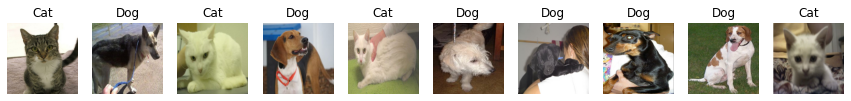

In [12]:
for x,y in ds_train:
    print(f"Training batch shape: features={x.shape}, labels={y.shape}")
    x_sample, y_sample = x,y
    break
    
display_dataset(x_sample.numpy().astype(np.uint8),np.expand_dims(y_sample,1),classes=ds_train.class_names)

> **Note**: All images in the dataset are represented as floatint point tensors with range 0-255. Before passing them to the neural network, we need to scale those values into 0-1 range. When plotting images, we either need to do the same, or convert values to the `int` type (which we do in the code above), in order to show `matplotlib` that we want to plot the original unscaled image.

## Pre-trained models

There are many pre-trained neural networks for image classification. Many of those models are available inside the `keras.applications` namespace, and even more models can be found on the Internet. Let's see how the simplest pre-trained model (VGG-16) can be loaded and used.

> In the sandbox environment, we need to explicitly load the weights of pre-trained VGG-16 network to a local directory. If you are running the code in local notebook environment, you can skip the following cell.

In [ ]:
# Download model weights in the sandbox environment
!mkdir -p ~/.keras/models
!wget -P ~/.keras/models -q https://mslearntensorflowlp.blob.core.windows.net/models/vgg16_weights_tf_dim_ordering_tf_kernels.h5
!wget -P ~/.keras/models -q https://mslearntensorflowlp.blob.core.windows.net/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
!wget -P ~/.keras/models -q https://mslearntensorflowlp.blob.core.windows.net/models/imagenet_class_index.json

In [15]:
vgg = keras.applications.VGG16()
inp = keras.applications.vgg16.preprocess_input(x_sample[:1])

res = vgg(inp)
print(f"Most probable class = {tf.argmax(res,1)}")

keras.applications.vgg16.decode_predictions(res.numpy())

Most probable class = [281]


[[('n02123045', 'tabby', 0.7269167),
  ('n02123159', 'tiger_cat', 0.18427314),
  ('n02124075', 'Egyptian_cat', 0.07865786),
  ('n03223299', 'doormat', 0.0015196853),
  ('n02127052', 'lynx', 0.0009609928)]]

There are a couple of important things here:
* Before passing an input to any pre-trained network it has to be pre-processed in a certain way. This is done by calling corresponding `preprocess_input` function, which receives a batch of images, and returns their processed form. In the case of VGG-16, images are normalized, and some pre-defined average value for each channels is subtracted. That is because VGG-16 was originally trained with this pre-processing.
* Neural network is applied to the input batch, and we receive as the result a batch of 1000-element tensors that show probability of each class. We can find the most probable class number by calling `argmax` on this tensor.
* Obtained result is a [number of an `ImageNet` class](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). To make sense of this result, we can also use `decode_predictions` function, that returns top n classes together with their names.

Let's see the architecture of the VGG-16 network:

In [16]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## GPU computations

Deep neural networks require quite a lot of computational power to run. If it is available use GPU acceleration to speed up training. Luckily, Keras automatically speeds up the computations on the GPU if it is available. We can check if TensorFlow is able to use GPU using the following code:

In [17]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Extracting VGG features

If we want to use VGG-16 to extract features from our images, we need the model without the final classification layers. We can instantiate VGG-16 model without top layers using this code:

Shape after applying VGG-16: (7, 7, 512)


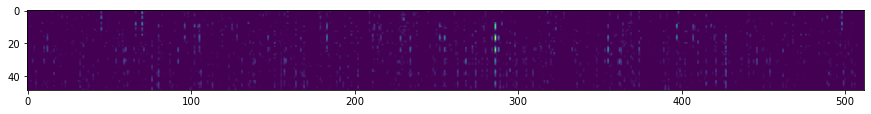

In [18]:
vgg = keras.applications.VGG16(include_top=False)

inp = keras.applications.vgg16.preprocess_input(x_sample[:1])
res = vgg(inp)
print(f"Shape after applying VGG-16: {res[0].shape}")
plt.figure(figsize=(15,3))
plt.imshow(res[0].numpy().reshape(-1,512))

The dimension of the feature tensor is 7x7x512, but in order to visualize it we had to reshape it to a 2D form.

Now let's try to see if those features can be used to classify images. Let's manually take some portion of images (50 minibatches, in our case), and pre-compute their feature vectors. We can use TensorFlow **dataset** API to do that. The `map` function takes a dataset and applies a given lambda-function to transform it. We use this mechanism to construct new datasets, `ds_features_train` and `ds_features_test`, that contain VGG-extracted features instead of original images.

In [19]:
num = batch_size*50
ds_features_train = ds_train.take(50).map(lambda x,y : (vgg(x),y))
ds_features_test = ds_test.take(10).map(lambda x,y : (vgg(x),y))

for x,y in ds_features_train:
    print(x.shape,y.shape)
    break

(64, 7, 7, 512) (64,)


We used construction `.take(50)` to limit the dataset size, to speed up our demonstration. You can of course perform this experiment on the full dataset.

Now that we have a dataset with extracted features, we can train a simple dense classifier to distinguish between cats and dogs. This network will take a feature vector of shape (7,7,512), and produce one output that corresponds either to a dog or to a cat. Because it is a binary classification, we use the `sigmoid` activation function and `binary_crossentropy` loss.

> This process can take a really long time, so you may even want to interrupt it if you are not patient. You may be wondering, why training on relatively small amount of data takes so much time! This is because the code above, which applies `vgg` feature extractor using `map`, is **lazy** - it does not in fact compute VGG features for all dataset at once, but it does it on demand. The call to VGG network happens during the training below.

In [20]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(7,7,512)),
    keras.layers.Dense(1,activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
hist = model.fit(ds_features_train, validation_data=ds_features_test)

50/50 [==============================] - 1919s 38s/step - loss: 1.4034 - acc: 0.9203 - val_loss: 0.6776 - val_acc: 0.9578


The result is great! We can distinguish between a cat and a dog with almost 95% accuracy! However, we have only tested this approach on a  subset of all images, because manual feature extraction takes a lot of time.

## Transfer learning using one VGG network

We can avoid manually pre-computing the features by using the original VGG-16 network as a whole during training, by adding feature extractor to our network as a first layer. 

The beauty of Keras architecture is that VGG-16 model that we have defined above can also be used as a layer in another neural network! We just need to construct a network with a dense classifier on top of it, and then train the whole network using back propagation.

In [6]:
model = keras.models.Sequential()
model.add(keras.applications.VGG16(include_top=False,input_shape=(224,224,3)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1,activation='sigmoid'))

model.layers[0].trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


This model looks like an end-to-end classification network, which takes an image and returns the class. However, the tricky thing is that we want VGG16 to act as a feature extractor, and not to be re-trained. Thus, we need to **freeze weights of convolutional feature extractor**. We can access the first layer of the network by calling `model.layers[0]`, and we just need to set `trainable` property to `False`.

> **Note**: Freezing of feature extractor weights is needed, because otherwise the untrained classifier layer can destroy the original pre-trained weights of convolutional extractor.

Notice that while the total number of parameters in our network is around 15 million, we are only training 25k parameters. All other parameters of the top-level convolutional filters are pre-trained. That is good, because we are able to fine-tune smaller number of parameters with smaller number of examples.

We will now train our network and see how good we can get. This will take a long time to train and do not worry if the execution seems frozen for some time.

In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
hist = model.fit(ds_train, validation_data=ds_test)

310/310 [==============================] - 265s 716ms/step - loss: 0.9917 - acc: 0.9512 - val_loss: 0.8156 - val_acc: 0.9671


We got a reasonably accurate cats vs. dogs classifier! 

## Saving and Loading the Model

Once we have trained the model, we can save the model architecture and trained weights to a file for future use:

In [8]:
model.save('data/cats_dogs.tf')

INFO:tensorflow:Assets written to: data/cats_dogs.tf/assets


We can then load the model from the file at any time and save the work for this training iteration.

In [9]:
model = keras.models.load_model('data/cats_dogs.tf')

## Fine-tuning transfer learning

Now we have trained the final classifier layer to classify images in our own dataset. However, we did not re-train the feature extractor and our model relied on the features that the model has learned on the ImageNet data. we need to start training the convolutional layers as well.

To do that, we can unfreeze the convolutional filter parameters that we have previously frozen. 

> **Note:** It is important that you freeze parameters first and perform several epochs of training in order to stabilize weights in the classification layer. If you immediately start training the network with unfrozen parameters, large errors are likely to destroy the pre-trained weights in the convolutional layers.

Our convolutional VGG-16 model is located inside the first layer, and it consists of many layers itself. We can have a look at its structure: 

In [10]:
model.layers[0].summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

We can unfreeze all layers of convolutional base like so:

In [ ]:
model.layers[0].trainable = True

We can first unfreeze just a few final layers of convolutions because they contain higher level patterns that are relevant for our images. For example, we can freeze all layers except the last 4: 

In [11]:
for i in range(len(model.layers[0].layers)-4):
    model.layers[0].layers[i].trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 7,104,513
Non-trainable params: 7,635,264
_________________________________________________________________


Observe that the number of trainable parameters increased significantly, but it is still around 50% of all parameters.

After unfreezing we can do a few more epochs of training. You can also select a bit lower learning rate in order to minimize the impact on the pre-trained weights. However, even with low learning rate, you can expect the accuracy to drop in the beginning of the training, until finally reaching a higher level than in the case of fixed weights.

> **Note:** This training happens much slower, because we need to propagate gradients back through many layers of the network!

In [12]:
hist = model.fit(ds_train, validation_data=ds_test)

310/310 [==============================] - 201s 645ms/step - loss: 0.5270 - acc: 0.9776 - val_loss: 1.4132 - val_acc: 0.9653


We are likely to achieve a higher training accuracy, because we are using more a powerful network with more parameters, but validation accuracy would increase only slightly.

Feel free to unfreeze a few more layers of the network and train more, to see if you are able to achieve higher accuracy!

## Other computer vision models

VGG-16 is one of the simplest computer vision architectures. Keras provides many more pre-trained networks. The most frequently used ones among those are **ResNet** architectures, developed by Microsoft, and **Inception** by Google. For example, let's explore the architecture of the simplest ResNet-50 model (ResNet is a family of models with different depth, you can try experimenting with ResNet-152 if you want to see what a really deep model looks like):

In [24]:
# Download model weights in the sandbox environment
!mkdir -p ~/.keras/models
!wget -P ~/.keras/models -q https://mslearntensorflowlp.blob.core.windows.net/models/resnet50_weights_tf_dim_ordering_tf_kernels.h5
# Uncomment the following line, if you also want to load ResNet-152
#!wget -P ~/.keras/models -q https://mslearntensorflowlp.blob.core.windows.net/models/resnet152_weights_tf_dim_ordering_tf_kernels.h5

In [26]:
resnet = keras.applications.ResNet50()
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

As you can see, the model contains the same familiar building blocks: convolutional layers, pooling layers and final dense classifier. We can use this model in exactly the same manner as we have been using VGG-16 for transfer learning. You can try experimenting with the code above, using different ResNet models as the base model, and see how accuracy changes.

## Batch Normalization

This network contains yet another type of layer: **Batch Normalization**. The idea of batch normalization is to bring values that flow through the neural network to right interval. Usually neural networks work best when all values are in the range of [-1,1] or [0,1], and that is the reason that we scale/normalize our input data accordingly. However, during training of a deep network, it can happen that values get significantly out of this range, which makes training problematic. Batch normalization layer computes average and standard deviation for all values of the current minibatch, and uses them to normalize the signal before passing it through a neural network layer. This significantly improves the stability of deep networks.

## Takeaway

With transfer learning we were able to quickly put together a classifier for our custom object classification task and achieve high accuracy. This example was not completely fair because original VGG-16 network was pre-trained to recognize cats and dogs, and thus we were just reusing most of the patterns that were already present in the network. You can expect lower accuracy other domain-specific objects, such as details on production line in a plant or different tree leaves.

You can see that more complex tasks require higher computational power and cannot be easily solved on the CPU. In the next unit, we will try to use a more lightweight implementation to train the same model using lower compute resources, which results in just slightly lower accuracy. 